## Ejercicio 10

El conjunto de datos **“Fingers”** consiste en una serie de imágenes de 64x64 píxeles con fondo negro donde en su centro se encuentra un mano que muestra una cantidad de dedos que va desde 0 a 5. La versión original de este conjunto de imágenes se encuentra en: https://www.kaggle.com/koryakinp/fingers  

<div style="text-align: center;">
    <img src='../../images/p4-ej10.png' width="40%">
</div>

Muchas veces se utilizan técnicas de procesamiento de imágenes para obtener características representativas (features extraction) de los objetos dentro de una imagen con el objetivo de simplificar el problema, reducir la dimensionalidad y/o reducir el costo de procesamiento. Bibliotecas como **OpenCV** o **SciKit-Learn** proveen funciones que permiten procesar imágenes y obtener valores estadísticos que caracterizan los objetos.


### a)

Utilice la función **regionprops** de **SciKitLearn** con algunas imágenes de ejemplo del dataset para  experimentar con las distintas características que extrae de la imagen de la mano.  

                area:     350.0
           area_bbox:     550.0
         area_convex:     392.0
         area_filled:     368.0
   axis_major_length:     25.55780753267881
   axis_minor_length:     19.60195181452277
                bbox:     (20, 21, 45, 43)
            centroid:     (np.float64(31.774285714285714), np.float64(30.765714285714285))
      centroid_local:     [11.77428571  9.76571429]
        eccentricity:     0.6416885623243128
equivalent_diameter_area:     21.11004122822376
        euler_number:     0
              extent:     0.6363636363636364
  feret_diameter_max:     25.96150997149434
      inertia_tensor:     [[24.35082449  2.35288163]
 [ 2.35288163 40.48905306]]
inertia_tensor_eigvals:     [np.float64(40.825095367340865), np.float64(24.014782183679536)]
               label:     1
         orientation:     -0.14186221690381084
           perimeter:     94.08326112068522
   perimeter_crofton:     89.19652469523821
               slice:     (slice(20, 45, None), sli

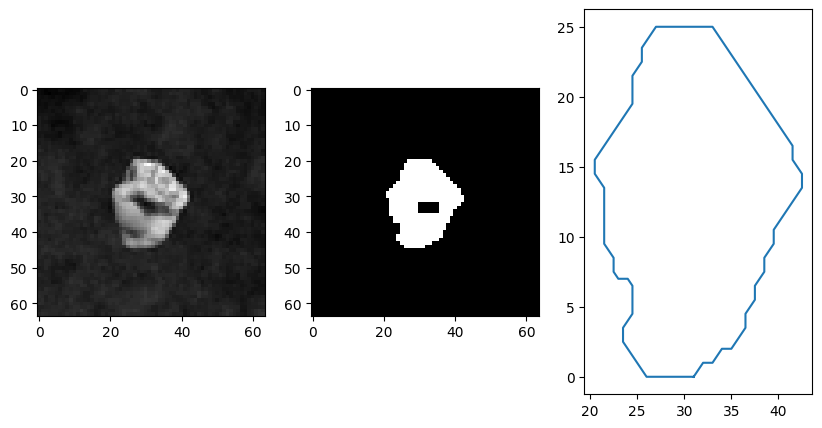

In [10]:
from skimage.measure import regionprops, find_contours

from skimage.filters import threshold_otsu
from skimage.morphology import closing, footprint_rectangle
from skimage.segmentation import clear_border
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import pandas as pd
import numpy as np

DATOS_DIR = "../../Datos/"

arch_img = DATOS_DIR + 'fingers/samples/0L.png'
imagen = io.imread(arch_img)

# busca umbral global con método estadístico de Otsu
umbral = threshold_otsu(imagen)

# binariza la imagen
imagen_bn = (imagen > umbral)*1

# cierra pequeños huecos/cortes que pudiera tener la imagen de la mano
imagen_bn = closing(imagen_bn, footprint_rectangle((3, 3)))

# remueve artefactos que pudiera tener la imagen en los bordes
imagen_lista = clear_border(imagen_bn)

# obtiene valores geométricos a partir de las regiones (objetos "aislados") en la imagen
regiones = regionprops(imagen_lista)

# datos de la primera región. Debería ser la única si la mano fue segmentada correctamente
region = regiones[0]

for prop in region:
  if prop not in ['convex_image', 'coords', 'image_filled', 'image', 'image_convex', 'moments', 'moments_central', 'moments_normalized', 'moments_hu']:
    print('%20s:    '% prop, region[prop])

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(imagen, cmap='gray')
axs[1].imshow(imagen_bn, cmap='gray')

contour = find_contours(imagen_bn, 0.5)[0]
y, x = contour.T

axs[2].plot(x, y.max()-y)


### b)

Implemente un script que convierta las imágenes en las carpetas **“test”** y **“train”** del dataset **“Fingers”** en dos archivos (uno por carpeta) separados por comas (csv). De todas las características que provee **regionprops**, tienen potencial aquellas que son independientes o se pueden independizar de las unidades (píxeles). Algunas de estas características pueden ser:  

- **filled_area:** cantidad de píxeles que contiene región (podría interpretarse como píxeles cuadrados).
- **major_axis_length:** longitud (en píxeles) del eje mayor de la elipse que mejor se ajusta a la región.
- **minor_axis_length:** longitud (en píxeles) del eje menor de la elipse que mejor se ajusta a la región.
- **perimeter:** cantidad de píxeles que forman el contorne de la región.
- **eccentricity:** excentricidad de la elipse de mejor ajuste, cerca de 0 es un círculo, mientras que cerca de 1 es una elipse más “larga”.
- **solidity:** razón entre la cantidad de píxeles de la región original y de la región convexa. Para generar una región convexa se completan los pixeles de forma de eliminar regiones cóncavas de una figura. La región convexa de una estrella de 5 puntas se convertirá en un pentágono al completarla.
- **extent:** razón entre pixeles de la región original y el rectángulo que la contiene (bounding box).


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.measure import find_contours, regionprops
from skimage.filters import threshold_otsu
from skimage.morphology import closing, footprint_rectangle
from skimage.segmentation import clear_border
from skimage import io
import pandas as pd
import numpy as np
import glob
import math

# funcion para extraer características geométricas de un objeto dentro de una imagen
def extraer_caracteristicas(imagen):
    # busca umbral global con método estadístico de Otsu
    umbral = threshold_otsu(imagen)

    # binariza la imagen
    imagen_bn = (imagen > umbral)*1

    # cierra pequeños huecos/cortes que pudiera tener la imagen de la mano
    imagen_bn = closing(imagen_bn, footprint_rectangle((3, 3)))

    # remueve artefactos que pudiera tener la imagen en los bordes
    imagen_lista = clear_border(imagen_bn)

    # extrae regiones de pixeles conectados, para los ejemplos debería haber
    # solo una única region. Para cada region obtiene distintas propiedades
    # que caracterizan a dicha region, ej: area, perimetro, centro, eje mayor y
    # menor, orientacion, coordenadas y área del recuadro que la contiene
    regiones = regionprops(imagen_lista)

    return (regiones[0], imagen_lista)


def mostrar_imagen(axs, imagen, cmap='gray'):
    # remueve ejes de los graficos
    axs.get_xaxis().set_ticks([])
    axs.get_yaxis().set_ticks([])

    axs.imshow(imagen, cmap=cmap)


# funcion para procesar todas las imagenes de manos mostrando dedos de una carpeta
# y generar un archivo csv con las características geometricas de lad mismas
def convertir_dataset(dir_orig, dir_arch_dest):

    # definición de columnas a guardar en el archivo csv
    columnas=['AreaNorm', 'PerimNorm', 'RazonEjes', 'Excentricidad', 'Solidez',
                               'Extension', 'CantDedos']

    # recupera nombres de archivos
    print(dir_orig)
    archivos = glob.glob(dir_orig+'*/*.png')

    data = np.empty((0, len(columnas)))

    # recorre la lista de archivos para procesar cada imagen. Guarda las características
    # en un arreglo temporal
    for nro, archivo in enumerate(archivos):

        print('\rTransformando %d imágenes: %6.2f%%' % (len(archivos), 100*(nro+1)/len(archivos)), end='')
        imagen = io.imread(archivo)

        # el nombre de archivo tiene la cantidad de dedos que se estan mostrando
        print(archivo[-6])
        cant_dedos = int(archivo[-6])

        # extrae caracteristicas
        props, imagen_bn = extraer_caracteristicas(imagen)

        area = props.filled_area                # area en pixeles (incluyendo huecos)
        ej_mayor = props.major_axis_length      # largo en pixeles del eje mayor en elipse de m. a.
        ej_menor = props.minor_axis_length      # largo en pixeles del eje menor en elipse de m. a.
        perim = props.perimeter                 # perimetro en pixeles
        # EXCENTRICIDAD: relacion con elipse que contiene la region.
        # cercano a 0 es un circulo, cercano a 1 es mas estirada la elipse
        excentr = props.eccentricity
        # SOLIDEZ: razon entre la cantidad de pixeles de la region original y de la
        # region convexa. Para generar una region convexa se completan los pixeles
        # de forma de eliminar regiones convexas de una figura. La región convexa
        # de una estrella de 5 puntas se convertira en un pentágono al completarla
        solidez = props.solidity
        # EXTENSION: razon entre pixeles de la region original y el rectangulo que
        # la contiene (bounding box)
        extension = props.extent

        # normaliza algunos valores para para que las unidades sean independientes de los pixeles
        area = area /  ((ej_mayor*ej_menor))
        perim = perim / ((ej_mayor+ej_menor)/2)
        #perim = perim / math.sqrt(ej_mayor*ej_menor)
        razon_ej = ej_menor/ej_mayor
        data = np.append(data, np.array([[area, perim, razon_ej, excentr,
                                          solidez, extension, cant_dedos]]), axis=0)

    df = pd.DataFrame(columns=columnas, data = data)
    df.to_csv(dir_arch_dest)

DATOS_DIR = "../../Datos/"
DEDOS_DIR = DATOS_DIR + 'fingers/'
convertir_dataset(DEDOS_DIR+'train/', DEDOS_DIR+'fingers_train.csv')
convertir_dataset(DEDOS_DIR+'test/' , DEDOS_DIR+'fingers_test.csv')

../../Datos/fingers/train/
Transformando 17999 imágenes:   0.01%0
Transformando 17999 imágenes:   0.01%0
Transformando 17999 imágenes:   0.02%0
Transformando 17999 imágenes:   0.02%0
Transformando 17999 imágenes:   0.03%0
Transformando 17999 imágenes:   0.03%0
Transformando 17999 imágenes:   0.04%0
Transformando 17999 imágenes:   0.04%0
Transformando 17999 imágenes:   0.05%0
Transformando 17999 imágenes:   0.06%0
Transformando 17999 imágenes:   0.06%0
Transformando 17999 imágenes:   0.07%0
Transformando 17999 imágenes:   0.07%0
Transformando 17999 imágenes:   0.08%0
Transformando 17999 imágenes:   0.08%0
Transformando 17999 imágenes:   0.09%0
Transformando 17999 imágenes:   0.09%0
Transformando 17999 imágenes:   0.10%0
Transformando 17999 imágenes:   0.11%0
Transformando 17999 imágenes:   0.11%0
Transformando 17999 imágenes:   0.12%0
Transformando 17999 imágenes:   0.12%0
Transformando 17999 imágenes:   0.13%0
Transformando 17999 imágenes:   0.13%0
Transformando 17999 imágenes:   0.14%

### c)

Entrene un modelo de multiperceptrón a partir del archivo de entrenamiento generado en el punto anterior.  


2025-09-30 07:44:26.330530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-30 07:44:26.330881: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 07:44:26.380513: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-30 07:44:27.390784: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118 (472.00 B)

 Trainable params: 118 (472.00 B)

 Non-trainable params: 0 (0.00 B)

450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step

 -------------------------------------------------------------------------------- 

Porcentaje de aciertos X_train : 99.972%
Reporte de métricas de entrenamiento:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2402
           1       1.00      1.00      1.00      2414
           2       1.00      1.00      1.00      2375
           3       1.00      1.00      1.00      2423
           4       1.00      1.00      1.00      2422
           5       1.00      1.00      1.00      2363

    accuracy                           1.00     14399
   macro avg       1.00      1.00      1.00     14399
weighted avg       1.00      1.00      1.00     14399

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step

 -------------------------------------------------------------------------------- 

Porcentaje de aciertos X_val : 99.889%
Reporte de métricas de validación:
              precision    recall  f1-score   su

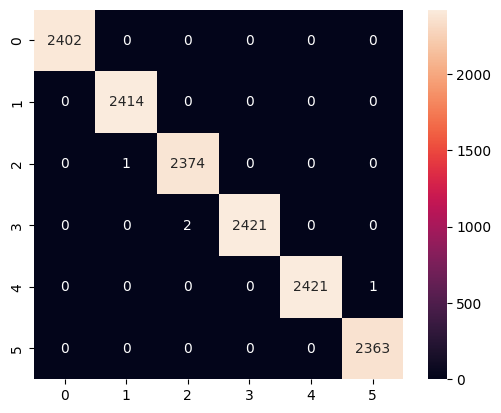

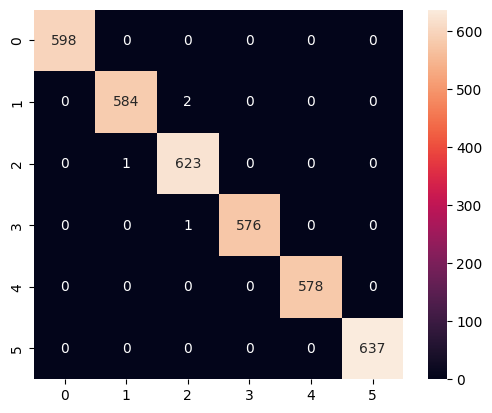

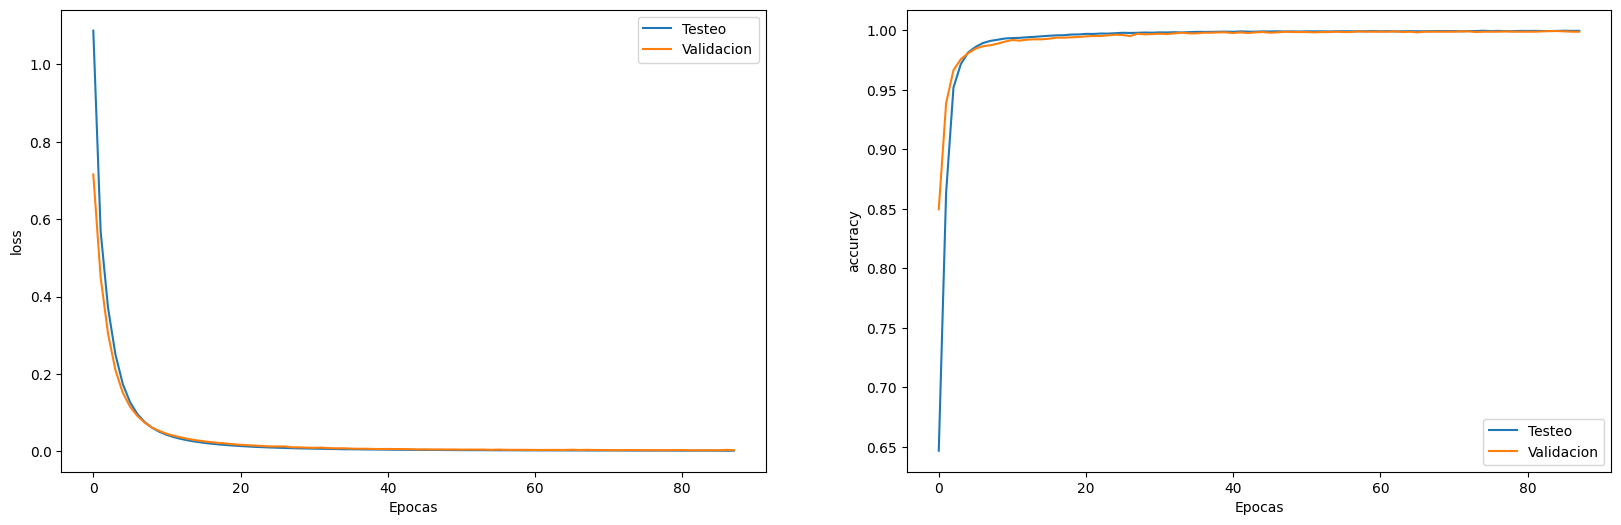

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, model_selection

from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import seaborn as sns

# %% CARGA DE DATASET
DATOS_DIR = "../../Datos/"
nom_archivo = DATOS_DIR + 'fingers/fingers_train.csv'
datos = pd.read_csv(nom_archivo)


# separa características y clase
X = np.array(datos.iloc[:, :-1])
Y = np.array(datos.iloc[:, -1])
nomClases = datos.iloc[:, -1].value_counts()

# Target codificado como one-hot
encoder = preprocessing.LabelEncoder()
Y_nro = encoder.fit_transform(Y)
Y_bin= to_categorical(Y_nro)

# %% --- CONJUNTOS DE ENTRENAMIENTO Y VALIDACION ---
X_train, X_val, Y_train, Y_val = model_selection.train_test_split( \
                                         X, Y_bin, test_size=0.20) #, random_state=42)

normalizador = preprocessing.StandardScaler()
X_train = normalizador.fit_transform(X_train)
X_val = normalizador.transform(X_val)

INPUT = X_train.shape[1]
OUTPUT = Y_train.shape[1]
HIDDEN = 8
EPOCHS = 200
BATCH_SIZE = 32
PATIENCE = 5
ACTIVATION = 'tanh'
OPTIMIZER = 'adam'


# %% CONSTRUCCION DEL MODELO
model = Sequential()
model.add(Dense(HIDDEN, input_shape=[INPUT], activation=ACTIVATION))
model.add(Dense(OUTPUT, activation='softmax'))
model.summary()  #-- muestra la cantidad de parámetros de la red


model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])

# %% ENTRENAMIENTO

# parada temprana para evitar el sobreajuste
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

# entrena el modelo y guarda la historia del progreso
history = model.fit(X_train,Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data = (X_val, Y_val), callbacks=[early_stop], verbose=0)

# predecir la salida del modelo
Y_pred = model.predict(X_train)
Y_pred_nro = np.argmax(Y_pred,axis=1)  #-- "conversión a entero"

Y_true = np.argmax(Y_train,axis=1)
print('\n','-'*80, '\n')
print("Porcentaje de aciertos X_train : %.3f%%" % (100*metrics.accuracy_score(Y_true, Y_pred_nro)))

report = metrics.classification_report(Y_true, Y_pred_nro)
print("Reporte de métricas de entrenamiento:\n%s" % report)
cm = metrics.confusion_matrix(Y_true, Y_pred_nro)

plt.figure()
sns.heatmap(cm, square=True,  annot=True, fmt='d')

# %% --- VALIDACION ---
Y_pred = model.predict(X_val)
Y_pred_nro = np.argmax(Y_pred,axis=1)  #-- conversión a entero

Y_true = np.argmax(Y_val,axis=1)
print('\n','-'*80, '\n')
print("Porcentaje de aciertos X_val : %.3f%%" % (100*metrics.accuracy_score(Y_true, Y_pred_nro)))

report = metrics.classification_report(Y_true, Y_pred_nro)
print("Reporte de métricas de validación:\n%s" % report)

cm = metrics.confusion_matrix(Y_true, Y_pred_nro)
plt.figure()
sns.heatmap(cm, square=True,  annot=True, fmt='d')

hist = history.history

def dibujar_curva(axs, value, epocas, hist):
    axs.plot(epocas, hist[value], label='Testeo')
    axs.plot(history.epoch, hist['val_'+value], label = 'Validacion')

    axs.set(xlabel="Epocas", ylabel=value)
    axs.legend()

fig, axs = plt.subplots(1,2, figsize=(20,6))

dibujar_curva(axs[0], 'loss', history.epoch, hist)
dibujar_curva(axs[1], 'accuracy', history.epoch, hist)


### d)

Reflexione acerca de las propiedades geométricas generadas a partir de un objeto/región de una imagen. ¿Cómo cree que afectaría la rotación, translación y escalado de un objeto/región dentro de la imagen?  

> **Conclusión:** La rotación, translación y escalado de las imágenes modificarán las características geométricas que utilizamos en el modelo, por lo tanto, el modelo no funcionará correctamente para esas imágenes modificadas.